In [195]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100

In [196]:
# create data
preprocess = transforms.Compose([
    transforms.Resize(84),
    transforms.CenterCrop(84),
    transforms.ToTensor()
])

train_dataset = CIFAR100("./data", transform=preprocess,
                          download=True, train=True)

val_dataset = CIFAR100("./data", transform=preprocess,
                        download=True, train=False)

train_loader = DataLoader(train_dataset,
                          batch_size=25, pin_memory=True,
                          num_workers=16, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [197]:
train_features, train_labels = next(iter(train_loader))

In [198]:
# class PadPrompter(nn.Module):
#     def __init__(self):
#         super(PadPrompter, self).__init__()
#         pad_size = 10
#         image_size = 84

#         self.base_size = image_size - pad_size*2
#         self.pad_up = nn.Parameter(torch.randn([1, 3, pad_size, image_size]))
#         self.pad_down = nn.Parameter(torch.randn([1, 3, pad_size, image_size]))
#         self.pad_left = nn.Parameter(torch.randn([1, 3, image_size - pad_size*2, pad_size]))
#         self.pad_right = nn.Parameter(torch.randn([1, 3, image_size - pad_size*2, pad_size]))

#     def forward(self, x):
        
#         print("x == ", x.shape)
        
#         base = torch.zeros(1, 3, self.base_size, self.base_size)
#         prompt = torch.cat([self.pad_left, base, self.pad_right], dim=3)
#         prompt = torch.cat([self.pad_up, prompt, self.pad_down], dim=2)
#         prompt = torch.cat(x.size(0) * [prompt])

#         return x + prompt

In [199]:
class PadPrompter2(nn.Module):
    def __init__(self, prompt_size, image_size):
        super(PadPrompter2, self).__init__()

        self.pad_size = prompt_size
        b, c, self.h, self.w = image_size

        self.base_size = self.w - self.pad_size * 2
        self.layer_dict = nn.ParameterDict()

        self.build_network()

    def build_network(self):

        self.layer_dict['pad_up'] = nn.Parameter(torch.empty([1, 3, self.pad_size, self.w]))
        self.layer_dict['pad_down'] = nn.Parameter(torch.empty([1, 3, self.pad_size, self.w]))
        self.layer_dict['pad_left'] = nn.Parameter(torch.empty([1, 3, self.w - self.pad_size*2, self.pad_size]))
        self.layer_dict['pad_right'] = nn.Parameter(torch.empty([1, 3, self.w - self.pad_size*2, self.pad_size]))

    def forward(self, x, params=None):

        print("x.shape == ", x.shape)

        if params is not None:
            # param이 지정될 경우 (inner-loop)
            param_dict = extract_top_level_dict(current_dict=params)
            pad_up = param_dict['pad_up']
            pad_down = param_dict['pad_down']
            pad_left = param_dict['pad_left']
            pad_right = param_dict['pad_right']
        else:
            # param이 지정되지 않을 경우 (outer-loop)
            pad_up = self.layer_dict['pad_up']
            pad_down = self.layer_dict['pad_down']
            pad_left = self.layer_dict['pad_left']
            pad_right = self.layer_dict['pad_right']
        
        
        print("pad_up.shape == ", pad_up.shape)
        print("pad_down.shape == ", pad_down.shape)
        print("pad_left.shape == ", pad_left.shape)
        print("pad_left.shape == ", pad_left.shape)

        base = torch.zeros(1, 3, self.base_size, self.base_size)
        prompt = torch.cat([pad_left, base, pad_right], dim=3)
        prompt = torch.cat([pad_up, prompt, pad_down], dim=2)
        prompt = torch.cat(x.size(0) * [prompt])

        return x + prompt

In [200]:
prompt1 = PadPrompter()
prompt2 = PadPrompter2(prompt_size=10, image_size=(2,3,84,84))

Feature batch shape: torch.Size([25, 3, 84, 84])
Labels batch shape: torch.Size([25])


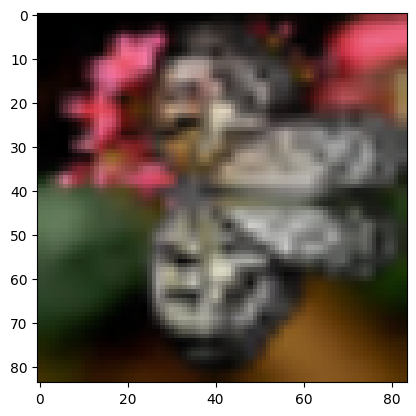

Label: 14


In [201]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].T
image = train_features[0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [202]:
len(train_features)

25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x.shape ==  torch.Size([25, 3, 84, 84])
pad_up.shape ==  torch.Size([1, 3, 10, 84])
pad_down.shape ==  torch.Size([1, 3, 10, 84])
pad_left.shape ==  torch.Size([1, 3, 64, 10])
pad_left.shape ==  torch.Size([1, 3, 64, 10])


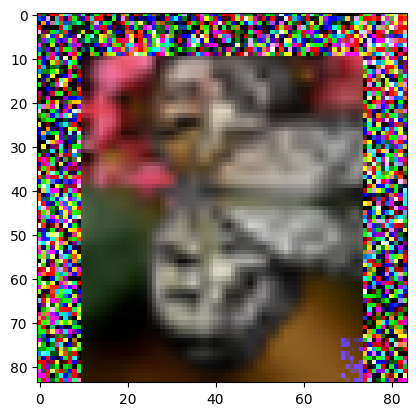

In [204]:
prompted_images = prompt2(train_features)

numpy_data = prompted_images[0].detach().numpy()

plt.imshow(numpy_data.T, cmap="gray")
plt.show()